In [1]:
%matplotlib inline

$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\a}{\mathbf{a}}$
We have a set of numbers $\a$, and we want to flip their signs such that the numbers sum to zero, with the minimum possible number of flips. This may be reformulated as an [integer linear programming (ILP)](http://en.wikipedia.org/wiki/Integer_programming)  problem.

The vector $\x$ is a list of binary coefficients, where each $x_i \in \{0, 1\}$. The problem is:

$$\begin{align} 
\textrm{mininimse} & \sum_{i=1}^n x_i \\
\textrm{subject to} & \sum_{i=1}^n (2x_i-1)a_i = 0 \\
\end{align}$$

The constraint may be rearranged:
$$
\textrm{subject to}  \sum_{i=1}^n 2x_ia_i = \sum_{i=1}^n a_i
$$

Hence, the final problem expressed using vectors:
$$\begin{align} 
\textrm{mininimse} \quad & ||\x|| \\
\textrm{subject to} \quad & \x^T(2\a) = ||\a|| \\
\end{align}$$

Thankfully, ILP solvers exist, so we don't actually have to come up with a decent algorithm for computing this directly. I chose PuLP because it was easy to install without third party dependancies and looked fairly simple to use with Python. See: https://pypi.python.org/pypi/PuLP/1.1



In [2]:
from pulp import LpProblem, LpVariable, lpSum, LpMinimize, LpAffineExpression, value, solvers
import numpy as np

def solve_problem(a):
    problem = LpProblem('prob', LpMinimize)

    # Define the set of coefficients (flips)
    x = [LpVariable('x_'+str(i), 0, 1, cat='Binary') for i in range(len(a))]

    # Set sum(x) to be the thing to minimise
    minimiser = lpSum(LpAffineExpression((var, 1) for var in x))
    problem += minimiser

    # Add sum(2*x*a)==sum(a), the problem constraint
    constraint = lpSum(LpAffineExpression((var, val*2) for var, val in zip(x, a))) == np.sum(a)
    problem += constraint 

    # Solve!
    if solvers.PULP_CBC_CMD().solve(problem):
        return problem, x
    else:
        raise Exception("Failed to find solution")
        
# This list of 120 numbers was generated with a known solution using 60 flips
# However, a smaller number should be possible
a = [3, 1, 4, 2, 5, 3, 2, 1, 7, 5, 6, 6, 3, 1, 5, 8, 2, 5, 5, 2, 2, 2, 1,
       5, 6, 1, 3, 4, 1, 3, 1, 3, 4, 8, 4, 2, 6, 6, 1, 2, 2, 1, 4, 7, 4, 1,
       6, 2, 1, 3, 1, 6, 6, 2, 2, 4, 3, 3, 3, 3, 3, 2, 1, 7, 1, 1, 1, 5, 2,
       2, 1, 2, 5, 7, 3, 2, 7, 5, 2, 5, 6, 3, 4, 4, 3, 1, 2, 5, 7, 5, 2, 2,
       6, 1, 1, 6, 2, 1, 8, 1, 3, 4, 2, 1, 4, 6, 2, 1, 3, 4, 3, 7, 3, 7, 3,
       1, 2, 1, 2, 2]


problem, x = solve_problem(a)

In [3]:
print "Number of flips: ", value(problem.objective)  
solution = np.array([-(v.varValue*2-1) * n for v, n in zip(x, a)])
print solution
print "Solution sums to:", np.sum(solution)



Number of flips:  33.0
[ 3.  1.  4.  2. -5.  3.  2.  1. -7. -5. -6. -6.  3.  1. -5. -8.  2. -5.
 -5.  2.  2.  2.  1. -5. -6.  1.  3.  4.  1.  3.  1.  3.  4. -8.  4.  2.
 -6. -6.  1.  2.  2.  1.  4. -7.  4.  1. -6.  2.  1.  3.  1. -6. -6.  2.
  2.  4.  3.  3.  3.  3.  3.  2.  1.  7.  1.  1.  1. -5.  2.  2.  1.  2.
 -5. -7.  3.  2. -7. -5.  2.  5. -6.  3.  4.  4.  3.  1.  2. -5. -7. -5.
  2.  2. -6.  1.  1. -6.  2.  1. -8.  1.  3.  4.  2.  1.  4. -6.  2.  1.
  3.  4.  3. -7.  3. -7.  3.  1.  2.  1.  2.  2.]
Solution sums to: 0.0


### Crude benchmarking...
Can we explore the speed of this solver as $\a$ grows?

Because I'm lazy, we'll just try by repeating the $\a$ array many times, so this is probably not very representative of reality.

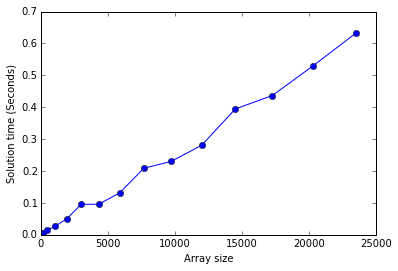

In [4]:
import matplotlib.pyplot as plt

times = []
sizes = []
for i in range(15):
    # Repeat the array i^2 times
    g = a * (i*i)
    # Solve the problem, record the time
    problem, x = solve_problem(g)
    sizes.append(len(g))
    times.append(problem.solutionTime)

plt.plot(sizes, times, 'o-')
plt.xlabel('Array size')
plt.ylabel('Solution time (Seconds)')